## Portfolio 2: Classification Models for Predicting User Ratings

This project involves building and evaluating classification models to predict whether a user likes or dislikes an item based on other features in the dataset.

### Dataset Overview

**Fields Description:**  
- `userId`: Unique identifier for the user.  
- `timestamp`: Time when the user rated the item.  
- `review`: User’s review comments.  
- `item`: Name of the item.  
- `rating`: Indicates if the user liked or disliked the item.  
- `helpfulness`: Average score indicating how helpful the review is (6 = helpful, 0 = not helpful).  
- `gender`: Gender of the user (`F` for female, `M` for male).  
- `category`: Category of the shopping item.  

### Project Objectives

The goal of this project is to determine the best-performing model for predicting user ratings. The workflow includes the following steps:

1. **Data Exploration and Cleaning**  
   - Remove abnormal instances and handle missing values.

2. **Feature Encoding**  
   - Convert categorical features into numerical values using encoding techniques.

3. **Feature Correlation Analysis**  
   - Analyze correlations between features to identify key predictors.

4. **Model Training and Evaluation**  
   - Train a **logistic regression model** on the dataset split and evaluate its accuracy in predicting `rating`.  
   - Train a **K-Nearest Neighbors (KNN) model** and assess its performance.

5. **Hyperparameter Tuning**  
   - Optimize the hyperparameter `K` in the KNN model to understand its impact on prediction accuracy.

This project demonstrates skills in data preprocessing, feature engineering, model development, and evaluation, showcasing the ability to effectively use classification techniques for predictive analysis.

In [124]:
# Import essential libraries
import pandas as pd
import numpy as np 

# Visualization libraries
import seaborn as sns  
import matplotlib.pyplot as plt  
%matplotlib inline 

# Scikit-learn modules for data preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV  # Data splitting and validation
from sklearn.preprocessing import OrdinalEncoder  # Encoding categorical features
from sklearn.feature_selection import RFE  # Recursive feature elimination for feature selection
from sklearn.feature_extraction.text import TfidfVectorizer  # Text feature extraction

# Machine Learning models
from sklearn.linear_model import LogisticRegression  # Logistic regression classifier
from sklearn import linear_model  # Additional linear models
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
from sklearn.cluster import KMeans  # K-means clustering

# Evaluation metrics
from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    confusion_matrix, 
    accuracy_score, 
    classification_report, 
    pairwise_distances
)  

# Libraries for hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist  


import warnings
warnings.filterwarnings('ignore')

In [125]:
# Read the csv file
df = pd.read_csv('Data/Portfolio 2.csv')
df.head(10)

,userId,timestamp,review,item,rating,helpfulness,gender,category
0,4259,11900,"Finally, Something for (Relatively) Nothing",MyPoints.com,like,4,F,Online Stores & Services
1,4259,12000,Shocking!,Sixth Sense,like,4,F,Movies
2,4259,12000,Simply Shaggadelic!,Austin Powers: The Spy Who Shagged Me,like,4,F,Movies
3,4259,12000,Better Than The First!,Toy Story 2,like,3,F,Movies
4,4259,12000,Blair Witch made me appreciate this,Star Wars Episode I: The Phantom Menace,dislike,4,F,Movies
5,4259,12100,Come here at least once in your life... stay a...,New York City,like,4,F,Hotels & Travel
6,4259,12400,"I joined for the free camera, and stood for no...",Earthlink,like,3,F,Online Stores & Services
7,4259,12700,They Should've Fooled the American Public,Blair Witch Project,dislike,4,F,Movies
8,4259,51600,A Short List of Things to Remember in NYC,New York City,like,4,F,Hotels & Travel
9,4259,60200,Do you know what a metaphysical can of worms t...,Being John Malkovich,like,4,F,Movies


In [126]:
# Display the shape and information of the DataFrame
print(f"The shape of the DataFrame is: {df.shape}")
print("\nDataFrame Information:")
df.info()

The shape of the DataFrame is: (2899, 8)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899 entries, 0 to 2898
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   userId       2899 non-null   int64 
 1   timestamp    2899 non-null   int64 
 2   review       2899 non-null   object
 3   item         2899 non-null   object
 4   rating       2899 non-null   object
 5   helpfulness  2899 non-null   int64 
 6   gender       2899 non-null   object
 7   category     2899 non-null   object
dtypes: int64(3), object(5)
memory usage: 181.3+ KB


In [127]:
# Handle NaN values in the data
df.isna().sum()

userId         0
timestamp      0
review         0
item           0
rating         0
helpfulness    0
gender         0
category       0
dtype: int64

Dataframe does not appear to contain any NaN values. Therefore, no changes to the dataframe are required 

In [128]:
# Convert categorical values into numerical values
ord_enc = OrdinalEncoder(dtype=int)
df[["review", "item", "rating", "gender", "category"]] = ord_enc.fit_transform(df[["review", "item", "rating", "gender", "category"]])
df.head(10)

,userId,timestamp,review,item,rating,helpfulness,gender,category
0,4259,11900,856,43,1,4,0,6
1,4259,12000,1985,62,1,4,0,5
2,4259,12000,2006,9,1,4,0,5
3,4259,12000,472,77,1,3,0,5
4,4259,12000,493,68,0,4,0,5
5,4259,12100,599,47,1,4,0,2
6,4259,12400,1232,23,1,3,0,6
7,4259,12700,2415,12,0,4,0,5
8,4259,51600,136,47,1,4,0,2
9,4259,60200,692,11,1,4,0,5


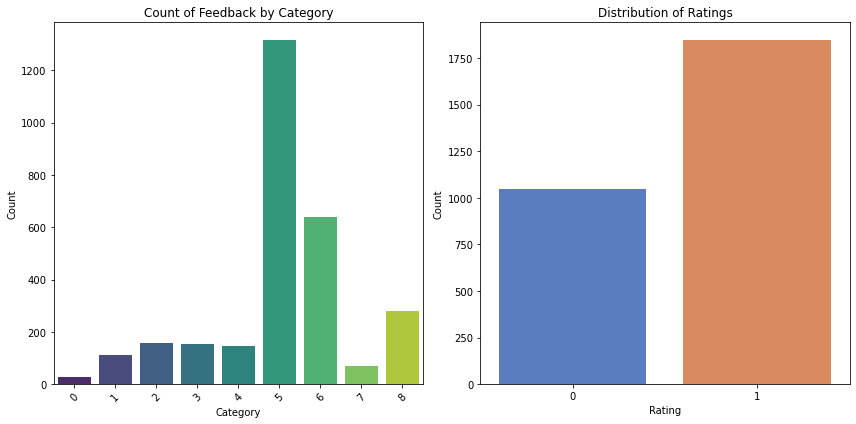

In [129]:
# Plot the distribution of categories and ratings
plt.figure(figsize=(12, 6))

# Plot the number of positive and negative feedback
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='category', palette='viridis')
plt.title("Count of Feedback by Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Plot the count of ratings
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='rating', palette='muted')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

**Overview**
1. The disproportionate distribution of feedback across categories suggests potential user preferences or popularity trends, with certain categories receiving significantly more attention than others.  

2. The dominance of positive ratings might indicate either a bias in user behavior or a genuinely high level of satisfaction with the items reviewed.

## Correlation between Features and Target Variable

In [130]:
# Investigate the correlation between helpfulness/gender/category/review and rating
df.corr()

,userId,timestamp,review,item,rating,helpfulness,gender,category
userId,1.000000,-0.036399,0.013212,-0.002618,0.010844,-0.016841,0.056183,0.015408
timestamp,-0.036399,1.000000,-0.025036,0.024337,0.011579,0.003638,-0.049244,0.037118
review,0.013212,-0.025036,1.000000,0.168119,-0.046935,0.016170,-0.014422,0.012047
item,-0.002618,0.024337,0.168119,1.000000,0.013629,-0.010780,0.006231,-0.054699
rating,0.010844,0.011579,-0.046935,0.013629,1.000000,-0.016850,0.022576,-0.116312
helpfulness,-0.016841,0.003638,0.016170,-0.010780,-0.016850,1.000000,-0.046627,-0.000189
gender,0.056183,-0.049244,-0.014422,0.006231,0.022576,-0.046627,1.000000,-0.017644
category,0.015408,0.037118,0.012047,-0.054699,-0.116312,-0.000189,-0.017644,1.000000


**Observation**

The analysis shows that category has the strongest connection to user ratings. On the other hand, factors like the timing of reviews and the user's gender are less relevant for understanding user preferences.

---
## Logistic Regression

In [131]:
# Split the data into training (80%) and testing data (20%)
X_train, X_test, y_train, y_test = train_test_split(df.drop(['rating'], axis=1), df['rating'], stratify=df['rating'], test_size=.2, random_state=7)

# Checking shapes of each
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train shape:  (2319, 7)
y_train shape:  (2319,)
X_test shape:  (580, 7)
y_test.shape:  (580,)


In [132]:
# Training model with all features
lr = LogisticRegression().fit(X_train, y_train)

# Making predictions on training and test set
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Calculating accuracy score on training set
print("Accuracy on training set: ", accuracy_score(y_train, y_pred_train))

# Calculating accuracy score on test set
print("Accuracy on test set: ", accuracy_score(y_test, y_pred_test))

Accuracy on training set:  0.6369124622682191
Accuracy on test set:  0.6344827586206897


The model performance is currently suboptimal, achieving only 63%, which is close to random guessing. To enhance performance, Recursive Feature Elimination (RFE) will be applied to identify the most important features and the model will be retrained using these selected features.

---
## Recursive Feature Estimation 

In [133]:
# Find the best number of features using RFE
rfe = RFE(estimator=lr, n_features_to_select=7, step=1)
rfe.fit(X_train, y_train)

supp = rfe.get_support()
print("Selected features:", X_train.columns[supp])
print("Coefficients: ", rfe.estimator_.coef_)

Selected features: Index(['userId', 'timestamp', 'review', 'item', 'helpfulness', 'gender',
       'category'],
      dtype='object')
Coefficients:  [[ 1.37536840e-05  1.36390041e-06 -1.69848493e-04  1.89447790e-03
   2.67496308e-01  7.21042805e-02 -1.11996606e-01]]


In [134]:
# Estimating accuracy scores for different number of features
acc_scores = []
for i in range(1, 8):  # Try selecting from 1 to 7 features
    selector = RFE(estimator=lr, n_features_to_select=i)
    selector.fit(X_train, y_train)

    # Predict using the selected features
    X_test_selected = X_test.loc[:, selector.support_]
    predicted = selector.estimator_.predict(X_test_selected)
    
    # Calculate and store the accuracy score
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)

# Identify the best number of features based on accuracy scores
best_num_features = acc_scores.index(max(acc_scores)) + 1
print("Best number of features:", best_num_features)

Best number of features: 5


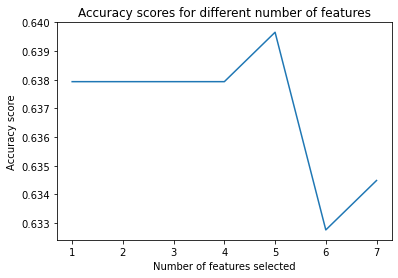

In [135]:
# Plot the accuracy scores for different numbers of features
plt.plot(range(1, 8), acc_scores)
plt.xlabel('Number of features selected')
plt.ylabel('Accuracy score')
plt.title('Accuracy scores for different number of features')
plt.show()

In [136]:
# Select and print the best features based on the best number of features
rfe_best = RFE(estimator=lr, n_features_to_select=best_num_features)
rfe_best.fit(X_train, y_train)
best_features = X_train.columns[rfe_best.support_]
print("Best features:", best_features)

Best features: Index(['review', 'item', 'helpfulness', 'gender', 'category'], dtype='object')


---
## Re-train the Model with the Five Most Important Features

In [137]:
# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['rating', 'userId', 'timestamp'], axis=1), df['rating'], stratify=df['rating'], test_size=.2, random_state=7)

# Checking shapes of each
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

# Training model with the top-5 features
lr = LogisticRegression().fit(X_train, y_train)

# making predictions on training and test set
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# calculating accuracy score on training set
print("Accuracy on training set: ", accuracy_score(y_train, y_pred_train))

# calculating accuracy score on test set
print("Accuracy on test set: ", accuracy_score(y_test, y_pred_test))

X_train shape:  (2319, 5)
y_train shape:  (2319,)
X_test shape:  (580, 5)
y_test.shape:  (580,)
Accuracy on training set:  0.6382061233290212
Accuracy on test set:  0.6396551724137931


**Observation**

The small difference in accuracy between the training and testing sets suggests that the model is not overfitting. While excluding irrelevant features slightly improved accuracy, the performance of the logistic regression model remains unsatisfactory. The next step is to train a more advanced K-Nearest Neighbors (KNN) model to assess if it yields better results.

---
## K-Nearest Neighbors

In [138]:
# Split training and test sets based on the important features
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.drop(['rating', 'userId', 'timestamp'], axis=1), df['rating'], stratify=df['rating'], test_size=.2, random_state=7)

In [139]:
# Define the search space for the hyperparameter
parameter_grid = {'n_neighbors': range(1, 41)}

# Create the KNN classifier
knn_clf = KNeighborsClassifier()

# Perform Grid Search with 10-fold cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(), parameter_grid, scoring='accuracy', cv=10)
grid_search.fit(X_train2, y_train2)

# Identify the best hyperparameter value
print('Best K value: ', grid_search.best_params_['n_neighbors'])
print('The accuracy is :', grid_search.best_score_)

Best K value:  35
The accuracy is : 0.6373488580385132


The model achieves an accuracy score of 0.6373 with \( K = 35 \), indicating a 63.73% likelihood of correctly predicting ratings on the testing set.

In [148]:
# Testing accuracy 
knn_clf = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_clf.fit(X_train2, y_train2)
print('The accuracy is :', accuracy_score(y_test2, knn_clf.predict(X_test2)))

The accuracy is : 0.6068965517241379


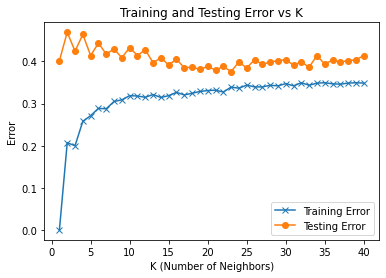

In [140]:
# Evaluate errors for different values of K
training_error, testing_error = [], []

# Loop to compute errors for different values of K (from 1 to 40)
for i in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train2, y_train2)
    training_error.append(1.0 - accuracy_score(clf.predict(X_train2), y_train2))
    testing_error.append(1.0 - accuracy_score(clf.predict(X_test2), y_test2))

# Plot training and testing errors
plt.plot(range(1, 41), training_error, marker='x', label='Training Error')
plt.plot(range(1, 41), testing_error, marker='o', label='Testing Error')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Error')
plt.title('Training and Testing Error vs K')
plt.legend(loc='best')
plt.show()

---
## Confusion Matrix Comparison

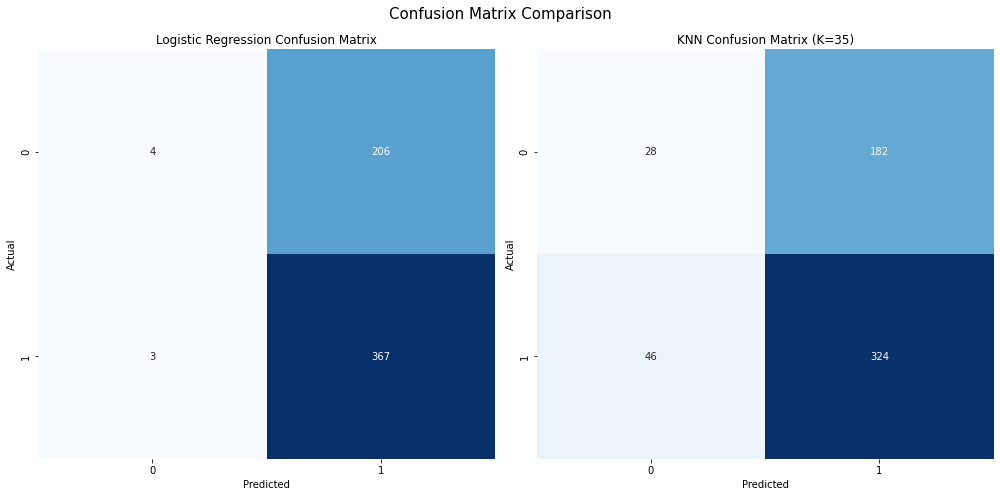

In [147]:
# Logistic Regression Confusion Matrix
y_pred_lr = lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)

# KNN Confusion Matrix
knn_best_model = KNeighborsClassifier(n_neighbors=35)
knn_best_model.fit(X_train2, y_train2)
y_pred_knn = knn_best_model.predict(X_test2)
cm_knn = confusion_matrix(y_test2, y_pred_knn)

# Plotting the confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Confusion Matrix Comparison", size=15)

# Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title('Logistic Regression Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# KNN
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False)
ax2.set_title(f'KNN Confusion Matrix (K={35})')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

**Observation**
- KNN was better at predicting users who didn’t like the item (28 errors vs. 4 for Logistic Regression).
- Logistic Regression outperformed KNN in predicting users who liked the item (367 correct predictions vs. 324).
- KNN made more mistakes by incorrectly predicting users who didn’t like the item (46 errors vs. 3 for Logistic Regression).
- Logistic Regression had more errors in predicting who liked the item (206 vs. 182 for KNN).

---
## Conclusion
Logistic Regression seems to be more inclined to predict a positive rating based on the dataset, as it correctly identified more users who liked the item. 
While KNN performed better in detecting users who didn’t like the item, it made more false positive errors, suggesting it was more uncertain in predicting who would like the item.
Overall, Logistic Regression performed better, with an accuracy 5% higher than KNN, making it the more reliable model for this dataset.